# k-Means Clustering: Implementation

k-Means is the most well-known clustering algorithm and was first proposed by Stuart Lloyd at Bell Labs in 1957. 

The algorithm finds K centroids and assigns each data point to exactly one cluster with the goal of minimizing the within-cluster variance (called inertia). It typically uses Euclidean distance but other metrics can also be used. k-Means assumes that clusters are spherical and of equal size and ignores the covariance among features.

The problem is computationally difficult (np-hard) because there are 𝐾N ways to partition the N observations into K clusters. The standard iterative algorithm delivers a local optimum for a given K and proceeds as follows:
1. Randomly define K cluster centers and assign points to nearest centroid
2. Repeat: 
    1. For each cluster, compute the centroid as the average of the features
    2. Assign each observation to the closest centroid
3. Convergence: assignments (or within-cluster variation) don’t change

This notebook demonstrates how to code the algorithm using python and visualizes the algorithm’s iterative optimization.

## Imports & Settings

In [2]:
%matplotlib inline
import numpy as np
from numpy.random import uniform, seed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import warnings
from time import sleep
from scipy.spatial.distance import cdist

In [3]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
seed(42)

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)  
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)  
plt.rc('ytick', labelsize=SMALL_SIZE)

## 2D Cluster Demo

In [5]:
def sample_clusters(n_points=500, n_dimensions=2, n_clusters=5, 
                    cluster_std=1):
    data, labels = make_blobs(n_samples=n_points, 
                               n_features=n_dimensions, 
                               centers=n_clusters, 
                               cluster_std=cluster_std, 
                               random_state=42)
    return data, labels

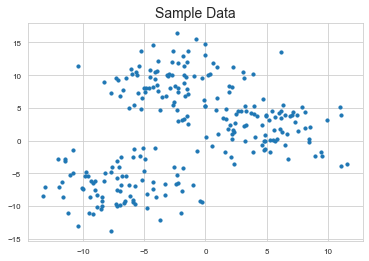

In [6]:
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=3, cluster_std=3)
x, y = data.T

plt.figure()
plt.scatter(x, y, s=10)
plt.title('Sample Data', fontsize=14);

## K-Means Implementation

### Assign Points to closest Centroid

In [7]:
def assign_points(centroids, data):
    dist = cdist(data, centroids)        # all pairwise distances
    assignments = np.argmin(dist, axis=1)   # centroid with min distance
    return assignments

### Move Centroids to best represent Clusters

In [8]:
def optimize_centroids(data, assignments):
    data_combined = np.column_stack((assignments.reshape(-1, 1), data))
    centroids = pd.DataFrame(data=data_combined).groupby(0).mean()
    return centroids.values

### Measure Distance from Points to Centroids

In [9]:
def distance_to_center(centroids, data, assignments):
    distance = 0
    for c, centroid in enumerate(centroids):
        assigned_points = data[assignments == c, :]
        distance += np.sum(cdist(assigned_points, centroid.reshape(-1, 2)))
    return distance

### Plot Clusters Dynamically

In [10]:
def plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step, ax, delay=2):
    ax.clear()
    ax.scatter(x, y, c=labels, s=15)
    # plot cluster centers
    centroid_x, centroid_y = centroids.T
    ax.scatter(*centroids.T, marker='o',  c='w', s=200, 
               edgecolor='k', zorder=9)
    for label, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker='${}$'.format(label), s=50, 
                   edgecolor='k', zorder=10)
    # plot links to cluster centers
    for i, label in enumerate(assignments):
        ax.plot([x[i], centroid_x[label]], [y[i], centroid_y[label]], 
                ls='--', color='white', lw=0.5)
    
    ax.set_title('Iteration: {} | {} | Inertia: {:,.2f}'.format(iteration, 
                                        step,  distance), fontsize=14)
    fig.canvas.draw()
    sleep(delay)

### Run K-Means Experiment

The following figures highlights how the resulting centroids partition the feature space into areas called Voronoi that delineate the clusters.

k-Means requires continuous or one-hot encoded categorical variables. Distance metrics are typically sensitive to scale so that standardizing features is necessary to make sure they have equal weight.

The result is optimal for the given initialization but alternative starting positions will produce different results. Hence, we compute multiple clusterings from different initial values and select the solution that minimizes within-cluster variance.

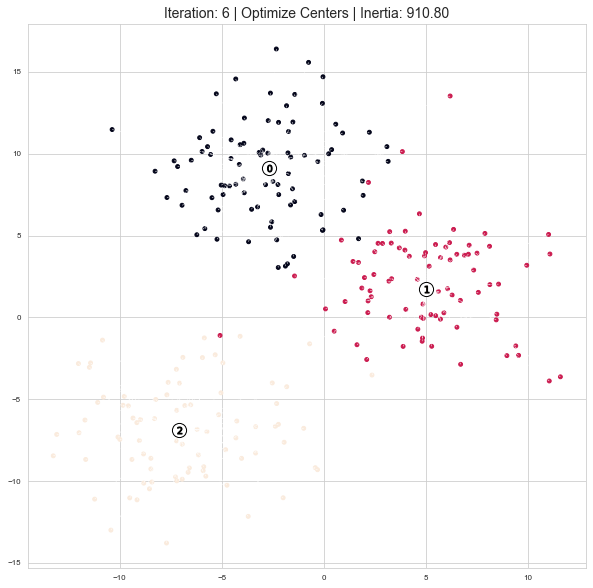

In [11]:
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, n_clusters=n_clusters, cluster_std=3)
x, y = data.T

x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))
distance = np.sum(np.min(cdist(data, centroids), axis=1))

fig, ax = plt.subplots(figsize=(10,10))
iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step='Assign Points', ax=ax)
    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta
    plot_clusters(x, y, labels, centroids, assignments, distance, 
                  iteration, step='Optimize Centers', ax=ax)
    iteration += 1
plt.savefig('kmeans_before', dpi=300)    

### Plot Voronoi Tesselation

In [12]:
def plot_voronoi(x, y, labels, centroids, assignments, distance, iteration, step, ax, delay=1):
    ax.clear()
    ax.scatter(x, y, c=labels, s=15)
    # plot cluster centers
    ax.scatter(*centroids.T, marker='o',  c='w', s=200, edgecolor='k', zorder=9)
    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker='${}$'.format(i), s=50, 
                   edgecolor='k', zorder=10)   

    # plot links to centroid
    cx, cy = centroids.T
    for i, label in enumerate(assignments):
        ax.plot([x[i], cx[label]], [y[i], cy[label]], ls='--', 
                color='white', lw=0.5)
    
    # plot voronoi
    xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), 
                         np.arange(y.min() - 1, y.max() + 1, .01))
    Z = assign_points(centroids, np.c_[xx.ravel(),  yy.ravel()]).reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
       cmap=plt.cm.viridis, aspect='auto', origin='lower', alpha=.2)
    
    ax.set_title('Iteration: {} | {} | Distance: {:,.1f}'.format(iteration, step, distance))
    fig.canvas.draw()
    sleep(delay)

### Run Voronoi Experiment

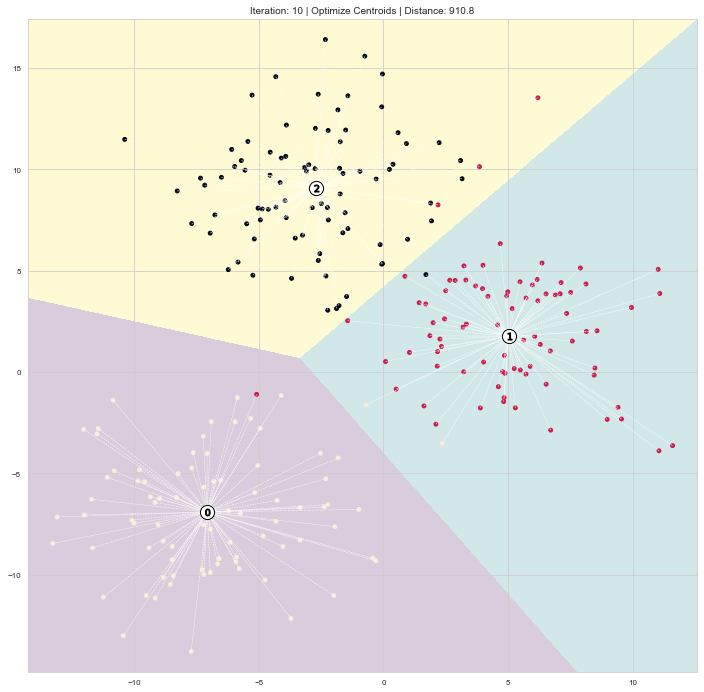

In [13]:
n_clusters = 3
data, labels = sample_clusters(n_points=250, n_dimensions=2, 
                               n_clusters=n_clusters, cluster_std=3)
x, y = data.T

x_init = uniform(x.min(), x.max(), size=n_clusters)
y_init = uniform(y.min(), y.max(), size=n_clusters)
centroids = np.column_stack((x_init, y_init))
distance = np.sum(np.min(cdist(data, centroids), axis=1))

fig, ax = plt.subplots(figsize=(12,12))
iteration, tolerance, delta = 0, 1e-4, np.inf
while delta > tolerance:
    assignments = assign_points(centroids, data)
    plot_voronoi(x, y, labels, centroids, assignments, distance, 
                 iteration, step='Assign Data', ax=ax)
    centroids = optimize_centroids(data, assignments)
    delta = distance - distance_to_center(centroids, data, assignments)
    distance -= delta
    plot_voronoi(x, y, labels, centroids, assignments, distance, 
                 iteration, step='Optimize Centroids', ax=ax)
    iteration += 1
plt.savefig('kmeans', dpi=300)    

## Strengths & Weaknesses

The strengths of k-Means include 
- its wide range of applicability, 
- fast convergence and 
- linear scalability to large data while producing clusters of even size. 

The weaknesses include 
- the need to tune the hyperparameter k, 
- it is not guaranteed to find a global optimum, 
- makes the restrictive assumption that clusters are spheres and features are not correlated. 
- It is also sensitive to outliers.